# Discovering Sentinel-1 SLC data via SARA and downloading via Thredds <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `DEA Sandbox` environment only
* **Products used:** 
[s1 slc granules](https://copernicus.nci.org.au/sara.client/#/explore?collection=S1)
* **Special requirements:** Need to pip install directly from git the `auscophub` and `PyRAT` Packages

## Background
This notebook demonstrates a recipe for working with Sentinel-1 SLC data to quickly identify possible burn scar areas using Complex data at the native resolution of the SAR sensor. This notebook was developed during a SAR Workshop day and will be progressed into a Real World Sample as actual fire based variability is noted. The sample area used in this notebook is over [Orroral Valley](https://www.google.com/maps/place/Orroral+Valley/@-35.6168882,148.6665058,10z/data=!4m13!1m7!3m6!1s0x6b17d73435882e61:0x2440e61df2404dce!2sOrroral+Valley!3b1!8m2!3d-35.61689!4d148.9466573!3m4!1s0x6b17d73435882e61:0x2440e61df2404dce!8m2!3d-35.61689!4d148.9466573).

## Description
This notebook sets up some basic steps to find and work with SLC data:

1. Install [Auscophub](https://github.com/CopernicusAustralasia/auscophub) Python package. 
1. Locate Datasets over Orroral Valley using [Copernicus Hub Australia](https://copernicus.nci.org.au/sara.client/#/explore).
2. Download the SARA results from [NCI Thredds](http://dapds00.nci.org.au/thredds/catalog/fj7/Copernicus/Sentinel-1/C-SAR/SLC/catalog.xml) and unpack them.
3. Perform some exploratory data extraction and plotting using GDAL [Complex Tiff](https://gdal.org/drivers/raster/gtiff.html) with Cfloat64 datatype, allocate enough RAM for this.
4. Install [PyRAT](https://github.com/birgander2/PyRAT) Python package.
5. Load Sentinel-1 SLC data for a specific granule and produce a preview.

***

## Getting started

This notebook requires 2 packages which should either be installed via - `!pip install` in a notebook cell or on console.

### Load packages

Load various packages and install additional ones in user mode

In [1]:
!export DISPLAY=0:0 && pip install --user git+https://github.com/whatnick/PyRAT
!pip install --user git+https://github.com/CopernicusAustralasia/auscophub

  Cloning https://github.com/whatnick/PyRAT to /tmp/pip-req-build-__k9byc0
  Running command git clone -q https://github.com/whatnick/PyRAT /tmp/pip-req-build-__k9byc0
  Created wheel for PyRAT: filename=PyRAT-0.62_oss-cp36-cp36m-linux_x86_64.whl size=2549580 sha256=75787b37caadc923a5a8cd22287d49a1a423bf4b5203b5960e9d7a5ce5138629
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmv9lt2f/wheels/3c/00/be/2e53666507254bc08cc05466762328055fd2e85d04a0bb2c32
Successfully built PyRAT
  Cloning https://github.com/CopernicusAustralasia/auscophub to /tmp/pip-req-build-r9jh_owv
  Running command git clone -q https://github.com/CopernicusAustralasia/auscophub /tmp/pip-req-build-r9jh_owv
  Created wheel for auscophub: filename=auscophub-1.1.9-py3-none-any.whl size=64920 sha256=b7601028385b478aa3855896339448fa15fe2661ebfdf8d75db582d7516f44b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-73fa2i_j/wheels/61/bd/1b/4c536f2e07599379dd2808768a10c0dc5beb89a05d53246719
Successfully built auscophub


In [2]:
import datacube
import requests
import zipfile
import logging
import os
import re
import urllib.request
import glob
import zipfile
from pylab import plot, imshow, figure, scatter
import matplotlib.pyplot as plt
from auscophub import saraclient
from shapely.geometry import Point
import osgeo.gdal as gdal
import numpy as np

### Connect to SARA and get some search results over Orroral
- Create a 0.01 degree buffer around the point of interest
- Perform a parametric search query and derive an array of results

In [3]:
orroral_polygon = Point(148.96,-35.58).buffer(0.01)
queryParams = [
               'collection=S1',
               'instrument=C-SAR',
               'productType=SLC',
               'startDate=2019-12-01',
               'completionDate=2020-02-04',
               'page=1',
               'orbitNumber=147',
              'geometry='+orroral_polygon.to_wkt()]
urlOpener = saraclient.makeUrlOpener()
results = saraclient.searchSara(urlOpener, 1, queryParams)

In [4]:
scene_ids = [x['properties']['productIdentifier'] for x in results]

### Convert the SARA results to NCI Thredds URL
- Use some parsing and internal knowledge of Thredds to figure out where dataset files are
- Download zip files from NCI, this is **slow**
- Unzip and create .SAFE directories with SLC data, this is **slow**

In [5]:
base_url = 'http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC'

In [6]:
from math import ceil, floor

def str_lat(lat):
    if lat < 0:
        return f'{abs(lat)}S'
    return f'{lat}N'
    
def str_lon(lon): 
    if lon < 0:
        return f'{abs(lon)}W'
    return f'{lon}E'
    
def infer_nci_folder(scene_props):
    ql_url = scene_props['quicklook']
    path_part = ql_url.rsplit('/',2)[1]
    x,y = scene_props['centroid']['coordinates']
    # Round x,y to 5
    round_x = 5 * floor(x/5)
    round_y = 5 * ceil(y/5)
    plus_round_x = round_x + 5
    plus_round_y = round_y - 5
    composed_path_part = f'{str_lat(round_y)}{str_lon(round_x)}-{str_lat(plus_round_y)}{str_lon(plus_round_x)}'
    if path_part != composed_path_part:
        logging.error(f'Expected {composed_path_part}, got {path_part}')
        raise Exception
    return path_part

def compose_url(scene_id):
    year,month = parse_ym(scene_id)
    full_url = f'{base_url}/{year}/{year}-{month}/{loc_folder}/{scene_id}.zip'
    return full_url

def parse_ym(granule_name):
    ym = granule_name.replace('S1A_IW_SLC__1SDV_','')[:6]
    return ym[:4],ym[-2:]

In [7]:
loc_folder = infer_nci_folder(results[0]['properties'])

In [8]:
for scene in scene_ids:
    url = compose_url(scene)
    print(url)
    filename = f'{scene}.zip'
    if not os.path.exists(filename):
        try:
            urllib.request.urlretrieve(url,filename)
        except HTTPError as hte:
            print(f"Failed to Download:{url}")

http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2020/2020-01/35S145E-40S150E/S1A_IW_SLC__1SDV_20200129T191613_20200129T191639_031019_039028_1537.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2020/2020-01/35S145E-40S150E/S1A_IW_SLC__1SDV_20200117T191613_20200117T191640_030844_038A00_75C1.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2020/2020-01/35S145E-40S150E/S1A_IW_SLC__1SDV_20200105T191613_20200105T191640_030669_0383E0_44C8.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2019/2019-12/35S145E-40S150E/S1A_IW_SLC__1SDV_20191224T191614_20191224T191641_030494_037DD5_C06C.zip
http://dapds00.nci.org.au/thredds/fileServer/fj7/Copernicus/Sentinel-1/C-SAR/SLC/2019/2019-12/35S145E-40S150E/S1A_IW_SLC__1SDV_20191212T191614_20191212T191641_030319_0377C8_F3C3.zip


In [9]:
for scene in scene_ids:
    filename = f'{scene}.zip'
    out_dir = f'{scene}.SAFE'
    print(out_dir)
    if not os.path.isdir(f'{scene}.SAFE'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            try:
                zip_ref.extractall('.')
            except:
                print(f"Corrupted :{filename}")
                os.unlink(filename)

S1A_IW_SLC__1SDV_20200129T191613_20200129T191639_031019_039028_1537.SAFE
S1A_IW_SLC__1SDV_20200117T191613_20200117T191640_030844_038A00_75C1.SAFE
S1A_IW_SLC__1SDV_20200105T191613_20200105T191640_030669_0383E0_44C8.SAFE
S1A_IW_SLC__1SDV_20191224T191614_20191224T191641_030494_037DD5_C06C.SAFE
S1A_IW_SLC__1SDV_20191212T191614_20191212T191641_030319_0377C8_F3C3.SAFE


### GDAL GCP Mechanism for Quick georeferencing
- SLC data carries a grid of GCP's for indicative georeferencing
- [Helmert transforms](https://proj.org/operations/transformations/helmert.html) can be performed for low distortion warping of SLC domain products approximately to geographic co-ordinates

In [10]:
s1_ds = gdal.Open('S1A_IW_SLC__1SDV_20200129T191613_20200129T191639_031019_039028_1537.SAFE')
sds_list = s1_ds.GetSubDatasets()
IW1_ds = gdal.Open(sds_list[2][0])
IW2_ds = gdal.Open(sds_list[5][0])
IW3_ds = gdal.Open(sds_list[8][0])

In [11]:
lon_1 = [gcp.GCPX for gcp in IW1_ds.GetGCPs()]
lat_1 = [gcp.GCPY for gcp in IW1_ds.GetGCPs()]
lon_2 = [gcp.GCPX for gcp in IW2_ds.GetGCPs()]
lat_2 = [gcp.GCPY for gcp in IW2_ds.GetGCPs()]
lon_3 = [gcp.GCPX for gcp in IW3_ds.GetGCPs()]
lat_3 = [gcp.GCPY for gcp in IW3_ds.GetGCPs()]

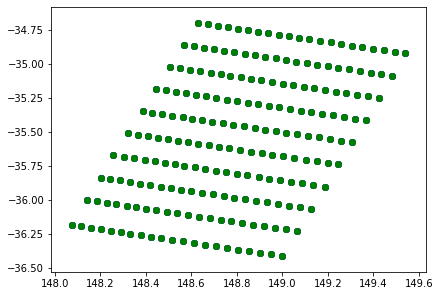

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
axs.scatter(lon_1,lat_1,color='k')
axs.scatter(lon_2,lat_2,color='b')
axs.scatter(lon_2,lat_2,color='g')

### Some exploratory plotting of Orroral SLC Data
- Plot image snippets to check alignment in pixel co-ordinated
- Plot Histograms to show any overall backscatter changes

In [13]:
datasets = [f'{scene}.SAFE/measurement' for scene in scene_ids]
data_collection = {}
for data in datasets:
    tiff_files = glob.glob(os.path.join(data,'*.tiff'))
    for tiff in tiff_files:
        if 's1a-iw2' in tiff:
            ds = gdal.Open(tiff)
            xsize = ds.RasterXSize
            ysize = ds.RasterYSize
            data = ds.ReadAsArray(int(xsize/4),int(ysize/4),1000,1000)
            data_collection[tiff] = data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


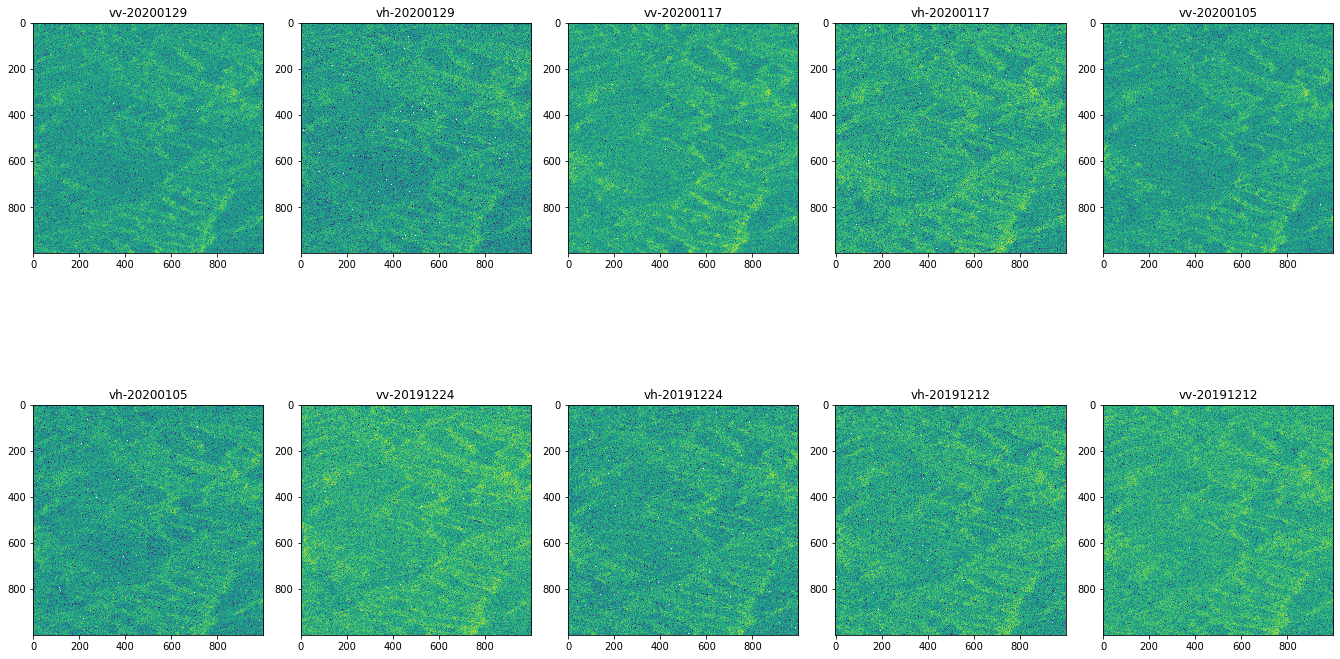

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=int(len(data_collection)/2), constrained_layout=True)
fig.set_size_inches(18.5, 10.5, forward=True)
i = 0
keys = list(data_collection.keys())
for ax in axs.flat:
    key = keys[i]
    decibel = np.log(np.absolute(data_collection[keys[i]])**2)*10
    ax.imshow(decibel)
    basename = os.path.basename(key)
    ax.set_title(basename[12:23])
    i += 1

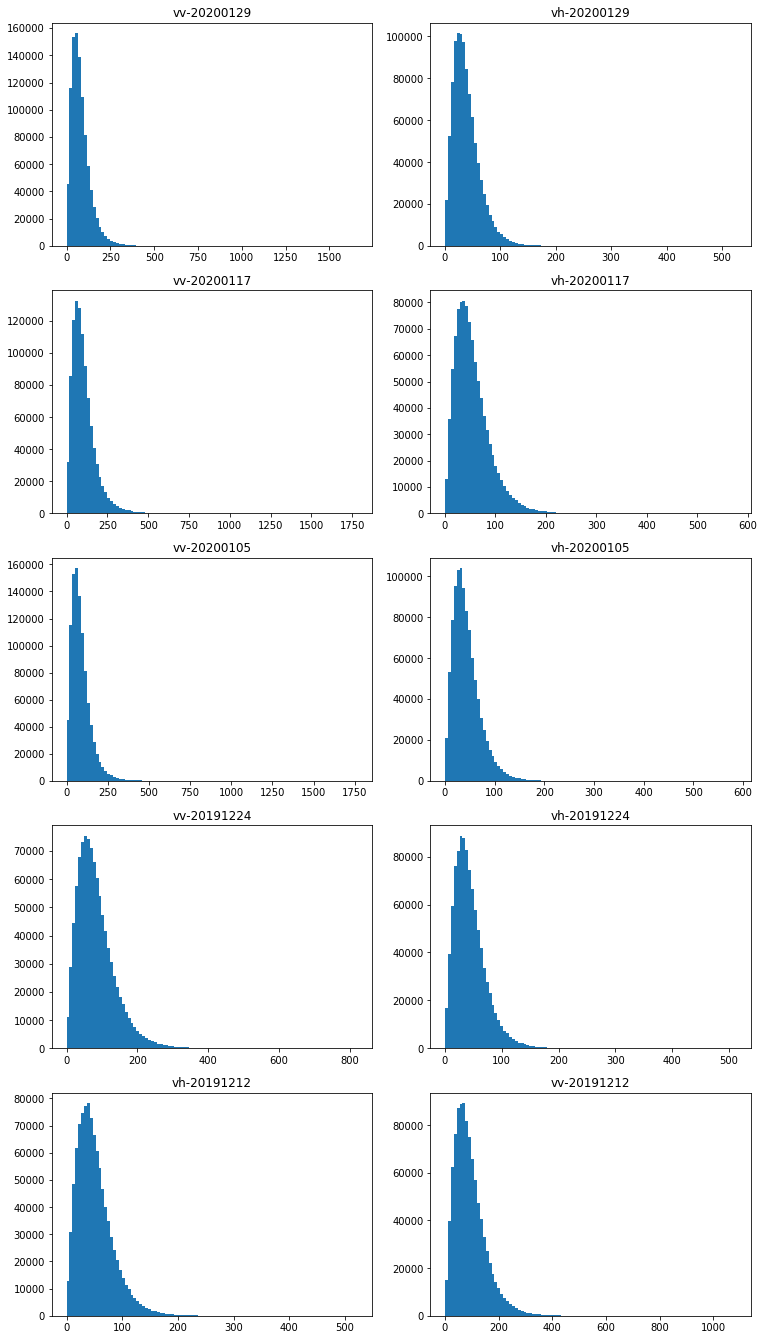

In [15]:
fig, axs = plt.subplots(nrows=int(len(data_collection)/2), ncols=2, constrained_layout=True)
fig.set_size_inches(10.5, 18.5, forward=True)
i = 0
keys = list(data_collection.keys())
for ax in axs.flat:
    key = keys[i]
    basename = os.path.basename(key)
    pol_date = basename[12:23]
    data = data_collection[keys[i]]
    data_no_nan = np.nan_to_num(np.absolute(data))
    counts, bins = np.histogram(data_no_nan.flatten(),bins=100)
    ax.hist(bins[:-1], bins=100, weights=counts)
    ax.set_title(pol_date)
    i += 1

### Load and manipulate data in PyRAT
- Load data from 1 SLC scene into PyRAT
- The load generates 2 Layers
- Perform some filtering and preview generation

In [16]:
os.environ['DISPLAY']='0:0'
from pyrat import *
pyrat_init()

  DEBUG: Loaded backend Qt5Agg version unknown.
  INFO: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
  
  Welcome to PyRAT (v0.62-oss)
  OS detected : linux
  Temporary directory: /tmp
  Pool with 16 workers initialised

  help() will show a list of available commands!
  
  Welcome to PyRAT (v0.62-oss)
  OS detected : linux
  Temporary directory: /tmp
  Pool with 16 workers initialised

  help() will show a list of available commands!


In [17]:
s1 = load.sentinel1(dir='S1A_IW_SLC__1SDV_20200129T191613_20200129T191639_031019_039028_1537.SAFE',swath=2)

  SENTINEL-1 IMPORT  {'dir': 'S1A_IW_SLC__1SDV_20200129T191613_20200129T191639_031019_039028_1537.SAFE', 'swath': 2}
  Activating ['/L1', '/L2']


In [18]:
info()


  /L1 *                          D complex64  (13572, 26843)
  /L2 *                          D complex64  (13572, 26843)


In [19]:
activate(['/L1','/L2'])

  Activating ['/L1', '/L2']


In [20]:
getmeta()

[{'ACQUISITION_START_TIME': '2020-01-29T19:16:13.003352',
  'ACQUISITION_STOP_TIME': '2020-01-29T19:16:39.966084',
  'BEAM_MODE': 'IW',
  'BEAM_SWATH': 'IW1',
  'FACILITY_IDENTIFIER': 'Copernicus S1 Core Ground Segment - DPA',
  'LINE_SPACING': '1.407137e+01',
  'MISSION_ID': 'S1A',
  'MODE': 'IW',
  'ORBIT_DIRECTION': 'DESCENDING',
  'ORBIT_NUMBER': '31019',
  'PIXEL_SPACING': '2.329562e+00',
  'PRODUCT_TYPE': 'SLC',
  'SATELLITE_IDENTIFIER': 'SENTINEL-1',
  'SENSOR_IDENTIFIER': 'SAR',
  'SWATH': 'IW2',
  'sensor': 'Sentinel-1'},
 {'ACQUISITION_START_TIME': '2020-01-29T19:16:13.003352',
  'ACQUISITION_STOP_TIME': '2020-01-29T19:16:39.966084',
  'BEAM_MODE': 'IW',
  'BEAM_SWATH': 'IW1',
  'FACILITY_IDENTIFIER': 'Copernicus S1 Core Ground Segment - DPA',
  'LINE_SPACING': '1.407137e+01',
  'MISSION_ID': 'S1A',
  'MODE': 'IW',
  'ORBIT_DIRECTION': 'DESCENDING',
  'ORBIT_NUMBER': '31019',
  'PIXEL_SPACING': '2.329562e+00',
  'PRODUCT_TYPE': 'SLC',
  'SATELLITE_IDENTIFIER': 'SENTINEL-1',
 

In [21]:
s1_l1_box = filter.boxcar(layer=s1[0])
save.pixmap('s1_l1.jpg',layer=s1[0])
save.pixmap('s1_l1_box.jpg', layer=s1_l1_box)

  BOXCAR FILTER  {'win': [7, 7], 'phase': False, 'layer': '/L1'}


  BOXCAR FILTER     : [############################# ] 98%

  Activating /L3
  EXPORT TO PIXMAP  {'file': 's1_l1.jpg', 'chscl': True, 'method': 'amplitude', 'scaling': 2.5, 'palette': 'bw linear', 'order': [0, 2, 1], 'layer': '/L1'}


  BOXCAR FILTER     : [##############################] 100%


  FINISHED SAVING IMAGE
  EXPORT TO PIXMAP  {'file': 's1_l1_box.jpg', 'chscl': True, 'method': 'amplitude', 'scaling': 2.5, 'palette': 'bw linear', 'order': [0, 2, 1], 'layer': '/L3'}
  FINISHED SAVING IMAGE


***

## Future Work

**Burn Scar Mapping** Fire Mapping in SAR Reference : https://www.mdpi.com/2072-4292/9/8/764/htm

**Entropy/Alpha and Statistical Analysis** Analyse them in Slant Range with [PyRAT](https://github.com/birgander2/PyRAT)

**Create Near-Real Time Results** Use [Helmert Transforms](https://en.wikipedia.org/wiki/Helmert_transformation) to utilize GCP's embedded in metadata to go from pixel domain/SLC domain to real-world coordinates.

**Create Accurate Results** Convert analysis results to Ground range/Orthorectified versions using [SNAP](http://step.esa.int/main/download/snap-download/)/[Gamma](https://www.gamma-rs.ch/)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2020

**Compatible datacube version:** 

In [22]:
print(datacube.__version__)

1.7+254.ge8d0a0c4.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)